In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import copy
from keras.layers import LSTM
from keras import optimizers as opt

from collections import Counter

import mbspbs10pc.model as mbs_model
from mbspbs10pc import read_activations, utils, mbs_online
%matplotlib inline

/home/samu/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data

In [2]:
labelsfile = '../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv'
datafile = '../../tmp/item_days_raw_data_.pkl'
dataset = utils.load_data_labels(datafile, labelsfile)
padded_mbs_seq, padded_timestamp_seq, tokenizer = utils.tokenize(dataset)
maxlen = padded_mbs_seq.shape[1]

# Split in training, validation, test sets
tr_set, v_set, ts_set = utils.train_validation_test_split(
    [padded_mbs_seq, padded_timestamp_seq], dataset['Class'],
    test_size=0.4, validation_size=0.1,
    verbose=False, random_state0=42, random_state1=420)

In [3]:
dataset.head()

,Seq,Class,mbs_seq,times_seq
PIN,,,,
568483,10990 0 23 16 725 0 10990 0 10990 0 10990 0 10...,1,10990 23 725 10990 10990 10990 10993 23 85311 ...,0 16 0 0 0 0 0 15 0 0 13 0 0 0 22 0 0 0 0 0 0 ...
923748,66653 0 65070 0 66515 5 10962 1 105 1 56807 42...,0,66653 65070 66515 10962 105 56807 10990 23 109...,0 0 5 1 1 42 0 26 35 0 0 0 9 0 0 0 5 0 0 0 21 ...
2035328,66536 0 74995 0 66512 0 66551 0 66608 0 66716 ...,0,66536 74995 66512 66551 66608 66716 66560 7392...,0 0 0 0 0 0 0 9 1 10 9 138 1 3 31 24 63 0 0 0 ...
2239386,10991 0 23 105 73928 0 66560 0 66515 0 66551 0...,1,10991 23 73928 66560 66515 66551 66536 2517 10...,0 105 0 0 0 0 4 2 27 1 1 7 0 18 132 0 0 0 1 0 ...
2244533,10990 0 23 74 23 0 10990 1 73928 0 66500 0 665...,1,10990 23 23 10990 73928 66500 66560 66551 23 1...,0 74 0 1 0 0 0 2 0 87 0 1 0 0 0 0 0 2 0 6 0 8 ...


In [4]:
zero_lenghts = [len(x) for x in dataset[dataset['Class'] == 0]['mbs_seq']]
ones_lenghts = [len(x) for x in dataset[dataset['Class'] == 1]['mbs_seq']]

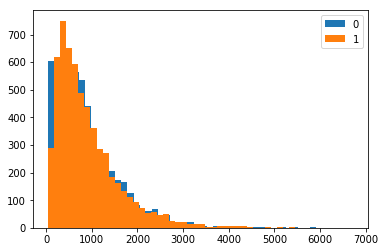

In [5]:
plt.hist(zero_lenghts, label='0', bins=50)
plt.hist(ones_lenghts, label='1', bins=50)
plt.legend()

In [6]:
neg = utils.flatten([x.split(' ') for x in dataset.loc[dataset['Class'] == 0, 'mbs_seq']])
pos = utils.flatten([x.split(' ') for x in dataset.loc[dataset['Class'] == 1, 'mbs_seq']])

In [113]:
from __future__ import division

In [114]:
neg_unique = utils.flatten([len(np.unique(x.split(' ')))/len(x.split(' ')) for x in dataset.loc[dataset['Class'] == 0, 'mbs_seq']])
pos_unique = utils.flatten([len(np.unique(x.split(' ')))/len(x.split(' ')) for x in dataset.loc[dataset['Class'] == 1, 'mbs_seq']])

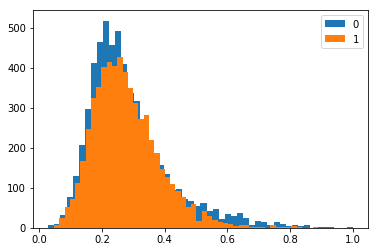

In [115]:
plt.hist(neg_unique, label='0', bins=50)
plt.hist(pos_unique, label='1', bins=50)
plt.legend()

In [118]:
np.median(neg_unique)

0.25555555555555554

In [119]:
np.median(pos_unique)

0.26277372262773724

In [7]:
neg_count = pd.DataFrame.from_dict(Counter(neg), orient='index').rename(columns={0: 'Counts'})
pos_count = pd.DataFrame.from_dict(Counter(pos), orient='index').rename(columns={0: 'Counts'})

In [94]:
#neg_count.nlargest(25, columns='Counts').index.ravel()
neg_count.loc['73938']

Counts    12615
Name: 73938, dtype: int64

In [95]:
#pos_count.nlargest(25, columns='Counts').index.ravel()
pos_count.loc['73938']

Counts    15934
Name: 73938, dtype: int64

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(ngram_range=(1, 1), tokenizer=lambda x: x.split(' '))

In [11]:
tmp = dataset['mbs_seq'].copy()

In [12]:
for i in tmp.index:
    tmp.loc[i] = tmp.loc[i].replace('727', '732')
    tmp.loc[i] = tmp.loc[i].replace('725', '732')

In [26]:
Xbow = bow.fit_transform(tmp)

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xbow, dataset['Class'].values,
                                                    test_size=0.4, random_state=42)

In [28]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
y_pred = lr.predict(X_test)

In [30]:
from sklearn import metrics

metrics.roc_auc_score(y_test, y_pred)

0.7044154107131206

In [31]:
word_map = {bow.vocabulary_[k]: k for k in bow.vocabulary_.keys()}

In [32]:
lr.coef_.ravel()[bow.vocabulary_['66833']]

-2.5316932680965536

In [39]:
coef = pd.DataFrame(index=[word_map[i] for i in range(len(lr.coef_[0]))],
                    data=lr.coef_.T, columns=['Coef'])

In [47]:
coef.loc['66608']

Coef    0.014195
Name: 66608, dtype: float64

In [ ]:
imap = pd.read_csv('')

In [41]:
from sklearn.feature_selection import chi2

stat, pval = chi2(X_train, y_train)

In [42]:
_chi2 = pd.DataFrame(index=[word_map[i] for i in range(len(lr.coef_[0]))],
                     data=np.vstack((stat, pval)).T, columns=['stat', 'pval'])

In [43]:
_chi2.loc[:, 'Coef'] = coef['Coef']

In [69]:
overall_count = Counter(utils.flatten([x.split(' ') for x in dataset['mbs_seq']]))
overall_count = pd.DataFrame.from_dict(overall_count, orient='index').rename(columns={0: 'overall'})

In [76]:
_chi2.loc[:, 'overall'] = overall_count.loc[_chi2.index, 'overall']

/home/samu/miniconda2/lib/python2.7/site-packages/pandas/core/indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [52]:
_chi2.loc['66608']

stat    2.981223e+01
pval    4.759804e-08
Coef    1.419525e-02
Name: 66608, dtype: float64

In [100]:
_chi2.loc[_chi2['overall'] > 1000,:].sort_values(by='Coef', ascending=True).head(50)

,stat,pval,Coef,overall
32090,1.020663,3.123619e-01,-0.739395,1007.0
10900,34.266055,4.806935e-09,-0.508614,6318.0
74998,8.155967,4.291970e-03,-0.379048,21041.0
74993,117.481882,2.251474e-27,-0.340230,6269.0
74995,486.947946,6.575193e-108,-0.322882,71766.0
12323,10.363589,1.285251e-03,-0.320403,1005.0
57963,0.020629,8.857939e-01,-0.286321,1578.0
10914,23.836130,1.048949e-06,-0.271676,2169.0
707,50.267475,1.341548e-12,-0.270169,1217.0
66593,6.831596,8.955918e-03,-0.262794,1077.0


Basic counter

In [ ]:
ll = utils.flatten([x.split(' ') for x in dataset['mbs_seq'].values.ravel()])
dd = pd.DataFrame.from_dict(Counter(ll), orient='index').rename(columns={0: 'Counts'})

In [ ]:
dd.nlargest(10, columns='Counts')

In [ ]:
# x = tr_set[0][0]
# t = tr_set[0][1].squeeze()

In [ ]:
# Build an inverse word map
word_map = {tokenizer.word_index[k]: k for k in tokenizer.word_index.keys()}
word_map[0] = 0

In [ ]:
item_map = pd.read_csv('../../mbspbs10pc/data/item_map.tsv', sep='\t', header=0, index_col=0,
                      usecols=['ITEM', 'Mapped_Item_Desc', 'CATEGORY_DESC'])
item_map.loc[0, :] = ['', '']
item_map.head()

# Load model

In [ ]:
model = mbs_model.build_model(mbs_input_shape=(maxlen,),
                              timestamp_input_shape=(maxlen, 1),
                              vocabulary_size=2774,
                              embedding_size=50,
                              recurrent_units=32,
                              dense_units=32,
                              bidirectional=True,
                              LSTMLayer=LSTM)

model.load_weights('../../tmp/single_run/proposed_auc_879/output_weights.h5')

# Visualize the attention weights

In [ ]:
D = copy(ts_set)

alpha = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='tsg_attention')[0]
omega = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='contribution')[0]

In [ ]:
W_fc = model.get_layer(name='fc').get_weights()[0]
W_out = model.get_layer(name='fc_output').get_weights()[0]
W = W_fc.dot(W_out)  # 50 x 1
We = model.get_layer(name='mbs_embedding').get_weights()[0]  # 2774 x 50
w = We[D[0][0]].dot(W).squeeze()  # 6341 x 445
print(w.shape)

In [ ]:
# avg_alpha = np.mean(alpha, axis=-1).squeeze()
avg_omega = np.mean(omega, axis=-1).squeeze()
avg_omega.shape

In [ ]:
c = w * avg_omega
print(c.shape)

In [ ]:
neg = np.where(D[1] == 0)[0]
pos = np.where(D[1] == 1)[0]

Group class attention:

In [ ]:
def zero_to_nan(row, p=75):
    out = np.array(row)
    _idx = np.where(np.abs(row) < np.percentile(np.abs(row), p))[0]
    out[_idx] = float('nan')
    return out


xaxis = np.arange(avg_omega.shape[1])

plt.figure(figsize=(14, 8))
plt.subplot(2,1,1)
for i in pos[:100]:
    plt.plot(xaxis, zero_to_nan(c[i, :].T), '.', color='C1')
plt.plot(xaxis, np.zeros_like(xaxis), '--', color='k', linewidth=0.5)
# plt.xlim([150, 250])
plt.ylim([-6, 6])
plt.title('positive samples')

plt.subplot(2,1,2)
for i in neg[:100]:
    plt.plot(xaxis, zero_to_nan(c[i, :].T), '.', color='C2')
plt.plot(xaxis, np.zeros_like(xaxis), '--', color='k', linewidth=0.5)
# plt.xlim([150, 250])
plt.ylim([-6, 6])
plt.title('negative samples')

plt.tight_layout();

Single attention:

In [ ]:
def attention_viz(i, color='C0'):
    # Load the mbs sequence from the dataset
    tokenized_seq = D[0][0][i]
    mbs_seq = np.array([word_map[tk] for tk in tokenized_seq])
    
    # Retrieve the corresponding attention vector
    attention = c[i].squeeze()
    
    # Filter out small attentions
    _idx = np.where(np.abs(attention) >= np.percentile(np.abs(attention), 75))[0]
    axis = np.arange(len(_idx))
    
    plt.bar(axis, attention[_idx], color=color)
    plt.xticks(axis, mbs_seq[_idx], rotation='vertical', fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('Subj id: {} [class {}]'.format(i, D[1][i]), fontsize=15)
    plt.tight_layout();
    

plt.figure(dpi=100, figsize=(20, 12))

plt.subplot(211)
attention_viz(1000, color='C0')

plt.subplot(212)
attention_viz(10, color='C1')

## Which MBS items get more attention?

In [ ]:
from tqdm import tqdm, trange

def get_MBS_attention():
    # Save absolute value of attention level for each MBS item
    attention_dict = {}
    for i in trange(D[0][0].shape[0]):
        # Load the mbs sequence from the dataset
        tokenized_seq = D[0][0][i]
        mbs_seq = np.array([word_map[tk] for tk in tokenized_seq])
        
        # Retrieve the corresponding attention vector
        attention = np.abs(c[i].squeeze())
        
        # Keep nonzero only
        nz = np.where(mbs_seq != '0')[0]
        mbs_seq, attention = mbs_seq[nz], attention[nz]
        
        # Keep only the TOP 5%
        top_idx = np.where(attention >= np.percentile(attention, 75))[0]
        mbs_seq, attention = mbs_seq[top_idx], attention[top_idx]

        # Update the dict
        for item, att in zip(mbs_seq, attention):
            if item in attention_dict:
                attention_dict[item].append(att)
            else:
                attention_dict[item] = [att]
    
    return attention_dict

attention = get_MBS_attention()
print(len(attention.keys()))

In [ ]:
lenghts = [len(attention[k]) for k in attention.keys()]
np.percentile(lenghts, 50)

In [ ]:
K = 100
filtered_attention = {}
for k in attention.keys():
    curr_att = np.array(attention[k])
    if len(curr_att) >= K:
        idx = np.arange(K)
        np.random.shuffle(idx)
        filtered_attention[k] = curr_att[idx]
print(len(filtered_attention.keys()))

In [ ]:
avg_attention = {k: np.sum(filtered_attention[k]) for k in filtered_attention.keys()}
dfa = pd.DataFrame(data=avg_attention.values(), index=avg_attention.keys(), columns=['Attention_overall'])
dfa['Mapped_Item_Desc'] = [item_map.loc[i, 'Mapped_Item_Desc'] for i in map(int, dfa.index)]
dfa['CATEGORY_DESC'] = [item_map.loc[i, 'CATEGORY_DESC'] for i in map(int, dfa.index)]

In [ ]:
dfa.nlargest(25, columns='Attention_overall')

In [ ]:
item = 66551
dfa.loc[str(item)]['Mapped_Item_Desc']

# Embedding viz

In [ ]:
X = read_activations.get_activations(model, D[0], print_shape_only=True, layer_name='pooling')[0]

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

X_r = PCA(n_components=3).fit_transform(X)

In [ ]:
%matplotlib inline
MAX = 250

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_r[pos[:MAX], 0], X_r[pos[:MAX], 1], X_r[pos[:MAX], 2], c='C0', label='pos')
ax.scatter(X_r[neg[:MAX], 0], X_r[neg[:MAX], 1], X_r[pos[:MAX], 2], c='C1', label='neg')
plt.legend();